In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime

from scipy.stats import shapiro
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

import shap 
import xgboost as xgb


warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'statsmodels'

In [4]:
texts, csvs = [], []
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        if filename[-3:] == 'csv':
            csvs.append(os.path.join(dirname, filename))
        else:
            texts.append(os.path.join(dirname, filename))
csvs

[]

In [5]:
def read_files():
    
    cab_rides = pd.read_csv('input/cab_rides.csv')

    weather = pd.read_csv('input/weather.csv')
        
    # convert the datetime fields from epoch to datetime
    cab_rides['timestamp'] = pd.to_datetime(cab_rides['time_stamp'], unit='ms')
    cab_rides['date_hour'] = cab_rides['timestamp'].dt.strftime('%Y-%m-%d:%H.%M.%S')
    weather['timestamp'] = pd.to_datetime(weather['time_stamp'], unit='s')
    weather['date_hour'] = weather['timestamp'].dt.strftime('%Y-%m-%d:%H.%M.%S')
    
    # drop redundant fields 
    cab_rides = cab_rides.drop('time_stamp', axis=1)
    weather = weather.drop('time_stamp', axis=1)
    
    return cab_rides, weather

rides_df, weather_df = read_files()
rides_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/input/cab_rides.csv'

In [4]:
weather_df.head()

,temp,location,clouds,pressure,rain,humidity,wind,timestamp,date_hour
0,42.42,Back Bay,1.0,1012.14,0.1228,0.77,11.25,2018-12-16 23:45:01,2018-12-16:23.45.01
1,42.43,Beacon Hill,1.0,1012.15,0.1846,0.76,11.32,2018-12-16 23:45:01,2018-12-16:23.45.01
2,42.50,Boston University,1.0,1012.15,0.1089,0.76,11.07,2018-12-16 23:45:01,2018-12-16:23.45.01
3,42.11,Fenway,1.0,1012.13,0.0969,0.77,11.09,2018-12-16 23:45:01,2018-12-16:23.45.01
4,43.13,Financial District,1.0,1012.14,0.1786,0.75,11.49,2018-12-16 23:45:01,2018-12-16:23.45.01


In [5]:
def merge_datasets():
    merged = pd.merge(left=rides_df,
                      right=weather_df,
                      left_on=['source', 'date_hour'],
                      right_on=['location', 'date_hour'],
                      suffixes=('_ride', '_weather'))

    # drop the merge fields -- location = source
    drop_cols = ['date_hour', 'location']
    merged = merged.drop(drop_cols, axis=1)

    # if rain is missing then there is no rain... fill with 0
    merged['rain'] = merged['rain'].fillna(0)
    return merged


df = merge_datasets()
df.head()

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,timestamp_ride,temp,clouds,pressure,rain,humidity,wind,timestamp_weather
0,0.55,Uber,South Station,Theatre District,7.0,1.0,74b72f4c-28bc-4640-a427-ec60b4b11f82,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-28 17:32:07.706,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
1,1.57,Uber,North End,Theatre District,18.0,1.0,e5aa2477-afb5-4b83-a69d-18ee7d2bfd1d,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
2,2.12,Lyft,Northeastern University,Theatre District,10.5,1.0,4d24470f-167a-4d1f-9cab-c123a0713491,lyft,Lyft,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
3,2.12,Lyft,Northeastern University,Theatre District,7.0,1.0,7902bfaf-5987-499b-9c04-222f4182c581,lyft_line,Shared,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07
4,2.12,Lyft,Northeastern University,Theatre District,16.5,1.0,91129083-ed19-41fd-b16a-06c729ff0790,lyft_plus,Lyft XL,2018-11-28 17:32:07.658,41.47,0.85,991.67,0.0,0.63,9.93,2018-11-28 17:32:07


In [6]:
(round(df.isnull().sum() / len(df), 2)*100).sort_values(ascending=False)

price                8.0
distance             0.0
timestamp_ride       0.0
wind                 0.0
humidity             0.0
rain                 0.0
pressure             0.0
clouds               0.0
temp                 0.0
name                 0.0
cab_type             0.0
product_id           0.0
id                   0.0
surge_multiplier     0.0
source               0.0
destination          0.0
timestamp_weather    0.0
dtype: float64

In [7]:
# split out a holdout set 
def split_data(data, holdout_size=0.2):
    
    sample_size = (1 - holdout_size)
    
    # remove the instances with no price value ~ predict for them at the very end?
    no_price = data[data['price'].isnull()].reset_index(drop=True)
    price = data[~data['price'].isnull()].reset_index(drop=True)
    
    # split the data into a holdout set and a training set
    holdout = price.sample(frac=sample_size, random_state=66)
    holdout_ids = holdout.index
    
    # remove the holdout observations from the original dataset
    train = price[~price.index.isin(holdout_ids)].reset_index(drop=True)
    holdout = holdout.reset_index(drop=True)
    
    return train, holdout, no_price

df, holdout, no_price_df = split_data(df, holdout_size=0.2)
df.head()

,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,timestamp_ride,temp,clouds,pressure,rain,humidity,wind,timestamp_weather
0,1.22,Lyft,Beacon Hill,Haymarket Square,10.5,1.0,6a435bb7-616a-48b9-b037-d9b8ace0f537,lyft_plus,Lyft XL,2018-11-28 18:32:08.243,41.26,0.99,991.70,0.0000,0.64,10.27,2018-11-28 18:32:08
1,2.04,Uber,Back Bay,Haymarket Square,29.5,1.0,9b74126d-52f9-4a47-a130-512208df9bb3,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-28 18:32:08.265,41.26,0.99,991.70,0.0000,0.64,10.27,2018-11-28 18:32:08
2,1.41,Uber,Boston University,Back Bay,17.0,1.0,0e745009-d49c-402b-9a99-72af6b8f8ba9,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-27 02:15:22.465,44.32,1.00,1003.12,0.1144,0.90,13.64,2018-11-27 02:15:22
3,1.46,Lyft,Fenway,Back Bay,7.0,1.0,0e4985ea-8481-4f77-822d-56501d08ba8b,lyft,Lyft,2018-11-27 02:15:22.278,44.32,1.00,1003.12,0.1144,0.90,13.64,2018-11-27 02:15:22
4,1.64,Uber,Back Bay,Northeastern University,8.5,1.0,ac11626c-7371-4e55-af31-33b6e8d45d17,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-28 21:32:07.833,40.23,0.86,994.12,0.0000,0.66,9.53,2018-11-28 21:32:07


<AxesSubplot:xlabel='distance', ylabel='price'>

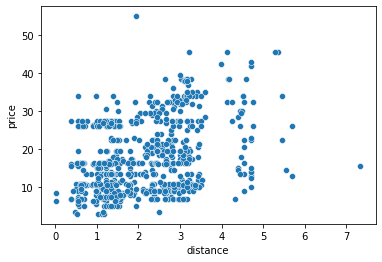

In [8]:
sns.scatterplot(x='distance', y='price', data=df) 

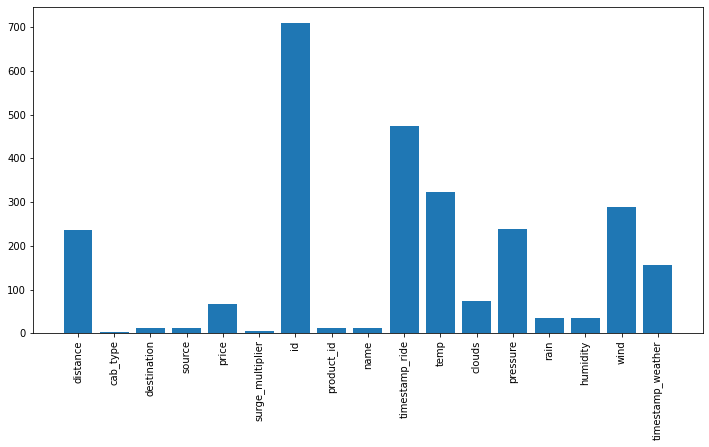

In [9]:
# generate the number of unique values in each column
columns, unique_values = df.columns, []

for i in columns:
    values = df[i].nunique()
    unique_values.append(values)
    
    
col_set = list(zip(columns, unique_values))
fig = plt.figure(figsize=(12, 6))
plt.bar(columns, unique_values)
plt.xticks(rotation=90)
plt.show()

In [10]:
def convert_data(data):
    
    data['uber'] = np.where(data['cab_type'] == 'Uber', 1, 0)
    data['rain_observed'] = np.where(data['rain'] > 0, 1, 0)
    
    # convert the name column to be more generic, so that 'XL' applies across both Uber & Lyft
    name_mapping = {'UberX': 'standard', 'Black': 'town_car', 'Black SUV': 'suv', 'UberXL': 'xl', 'UberPool': 'shared',
                    'WAV': 'accessible', 'Lyft': 'standard', 'Shared': 'shared', 'Lux Black': 'town_car', 
                    'Lux Black XL': 'suv', 'Lyft XL': 'xl', 'Lux': 'luxury'}
    
    data['product'] = data['name'].map(name_mapping)
    
    # convert the wind speed into bins -- https://www.weather.gov/pqr/wind
    data.loc[data['wind'] < 4, 'wind_strength'] = 0
    data.loc[((data['wind'] < 8) & (data['wind'] >= 4)), 'wind_strength'] = 1
    data.loc[((data['wind'] < 13) & (data['wind'] >= 8)), 'wind_strength'] = 2
    data.loc[data['wind'] >= 13, 'wind_strength'] = 3
    
    # convert the pressure into groups -- https://www.thoughtco.com/how-to-read-a-barometer-3444043
    data.loc[data['pressure'] < 1009.144, 'pressure_tag'] = 1
    data.loc[((data['pressure'] >= 1009.144) & (data['pressure'] <= 1022.689)), 'pressure_tag'] = 2
    data.loc[data['pressure'] > 1022.689, 'pressure_tag'] = 3

    # convert the temperature from F to Celsius
    data['temp'] = (data['temp'].sub(32)) / 1.8
    
    # create new features
    data['distance_x_multiplier'] = data['distance'].mul(data['surge_multiplier'])
    data['log_distance_x_multiplier'] = np.log(data['distance_x_multiplier'])
    data['weekday'] = data['timestamp_ride'].dt.weekday
    data['weekend'] = np.where(data['weekday'].isin([5, 6]), 1, 0)
    data['hour'] = data['timestamp_ride'].dt.hour
    
    # create features based on the trip route 
    data['route'] = (df['source'] + '-' + df['destination'])
    
    # create a single weather feature
    data.loc[data['rain'] > 0, 'weather'] = 'rain'
    data.loc[(data['clouds'] >= 0.75) & (data['rain'] == 0), 'weather'] = 'very_cloudy'
    data.loc[(data['rain'] == 0) & (data['wind_strength'] >= 2), 'weather'] = 'windy'
    data.loc[(data['clouds'] >= 0.5) & (data['clouds'] < 0.75) & (data['rain'] == 0), 'weather'] = 'cloudy'
    data.loc[(data['clouds'] < 0.5) & (data['rain'] == 0) & (data['humidity'] >= 0.75), 'weather'] = 'humid'
    data.loc[(data['clouds'] < 0.5) & (data['rain'] == 0) & (data['humidity'] < 0.75), 'weather'] = 'normal'
    
    # convert categorical features into features
    product_dummies = pd.get_dummies(data['product'], prefix='product')
    weather_dummies = pd.get_dummies(data['weather'], prefix='weather')
    data = pd.concat([data, product_dummies, weather_dummies], axis=1)
    

    # product_id = name; which is the type of ride called 
    drop_cols = ['cab_type', 'product_id', 'id', 'timestamp_weather', 'name',
                'pressure', 'wind', 'timestamp_ride', 'route', 'source', 'destination',
                'product', 'weather']
    data = data.drop(drop_cols, axis=1)
    
    return data 


df = convert_data(df)
df.head()

,distance,price,surge_multiplier,temp,clouds,rain,humidity,uber,rain_observed,wind_strength,...,product_standard,product_suv,product_town_car,product_xl,weather_cloudy,weather_humid,weather_normal,weather_rain,weather_very_cloudy,weather_windy
0,1.22,10.5,1.0,5.144444,0.99,0.0000,0.64,0,0,2.0,...,0,0,0,1,0,0,0,0,0,1
1,2.04,29.5,1.0,5.144444,0.99,0.0000,0.64,1,0,2.0,...,0,1,0,0,0,0,0,0,0,1
2,1.41,17.0,1.0,6.844444,1.00,0.1144,0.90,1,1,3.0,...,0,0,1,0,0,0,0,1,0,0
3,1.46,7.0,1.0,6.844444,1.00,0.1144,0.90,0,1,3.0,...,1,0,0,0,0,0,0,1,0,0
4,1.64,8.5,1.0,4.572222,0.86,0.0000,0.66,1,0,2.0,...,1,0,0,0,0,0,0,0,0,1


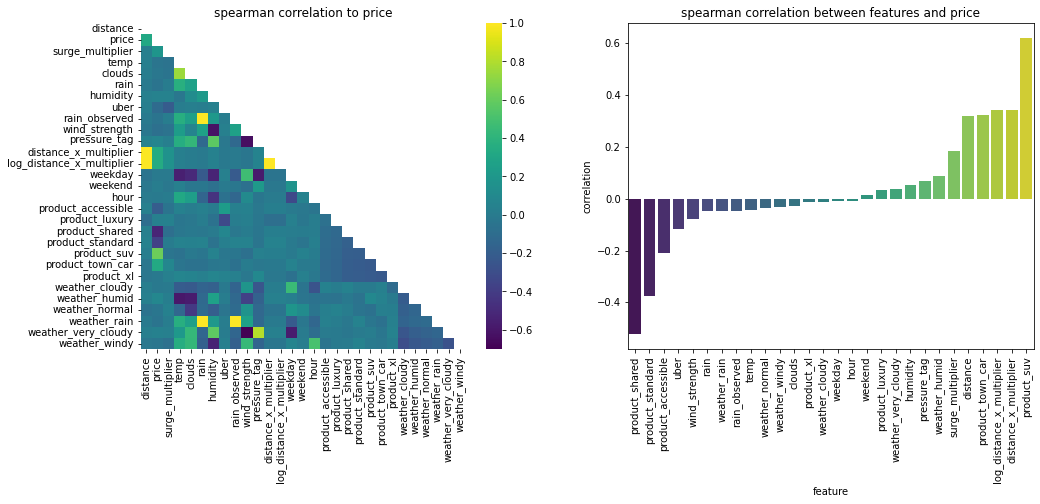

In [11]:
def heatmapper(data, corr_type='pearson'):
    corr_data = data.corr(method=corr_type)
    mask = np.triu(np.ones_like(corr_data, dtype='bool'))
    
    # create a line graph of correlations vs the target variable
    bar_data = corr_data['price'].reset_index()
    bar_data.columns = ['feature', 'correlation']
    bar_data = bar_data[bar_data['feature'] != 'price'].sort_values(by='correlation', ascending=True)
    
    # plot both the graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(corr_data, mask=mask, cmap='viridis', ax=ax1)
    sns.barplot(x='feature', y='correlation', data=bar_data, palette='viridis', ax=ax2)
    ax2.set_xticklabels(bar_data['feature'], rotation=90)
    ax1.set_title(f'{corr_type} correlation to price')
    ax2.set_title(f'{corr_type} correlation between features and price')
    plt.show()

    
heatmapper(df, corr_type='spearman')

Explore the features, to see which ones correlate with the targets and try to visualise the distribution of the field values.

Exploring distance


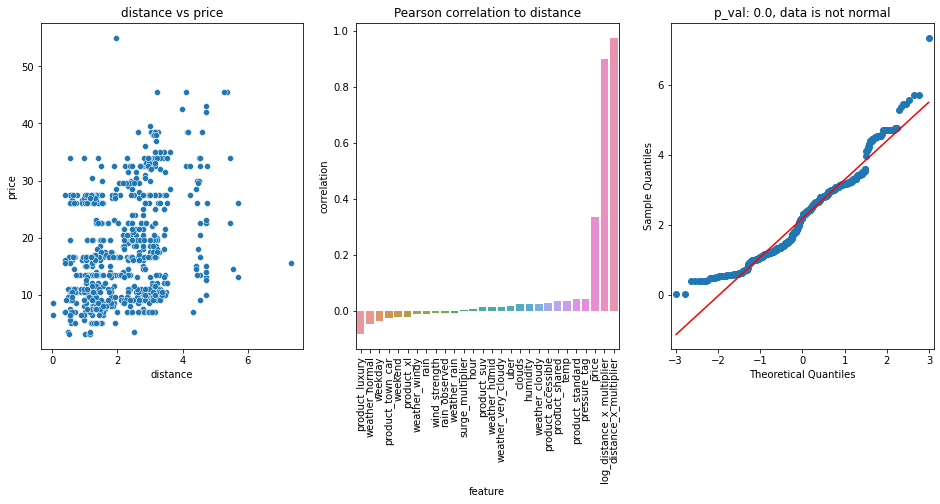





Exploring surge_multiplier


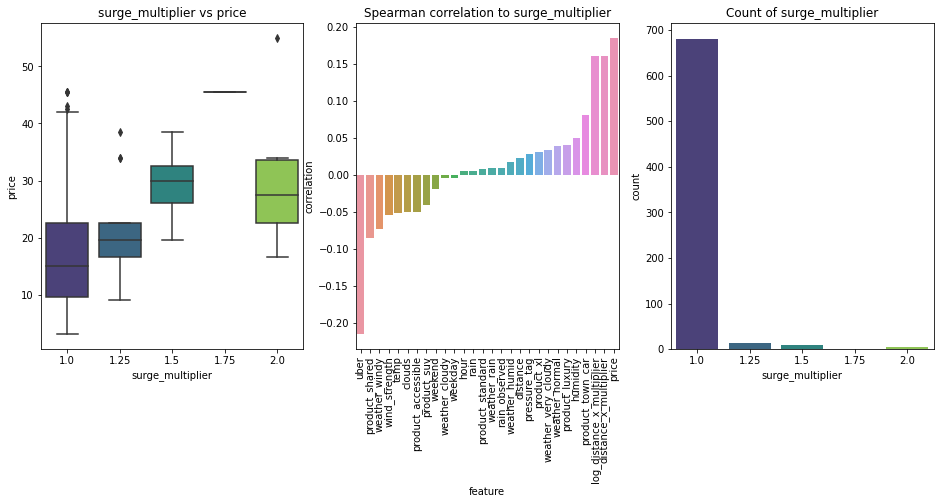





Exploring temp


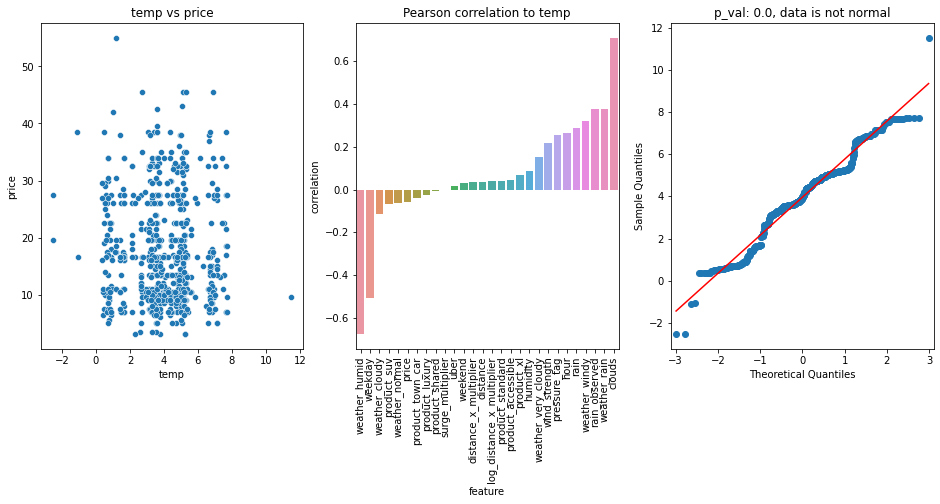





Exploring clouds


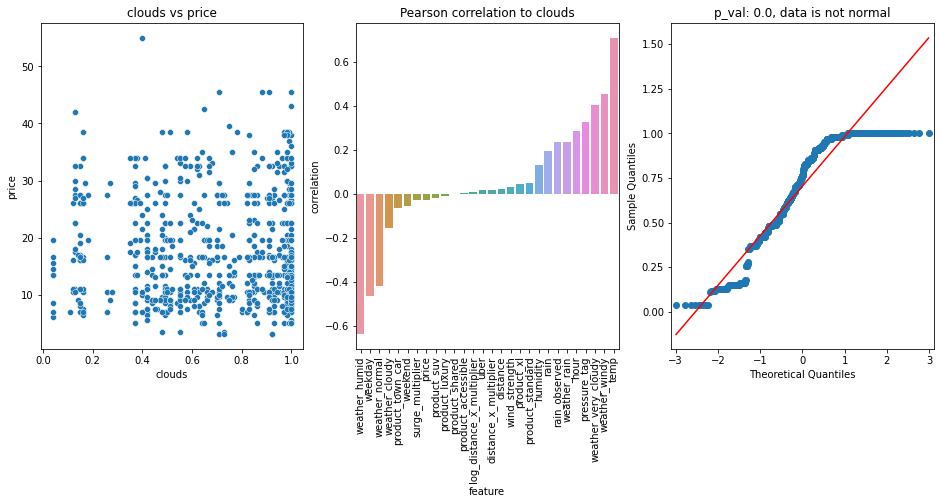





Exploring rain


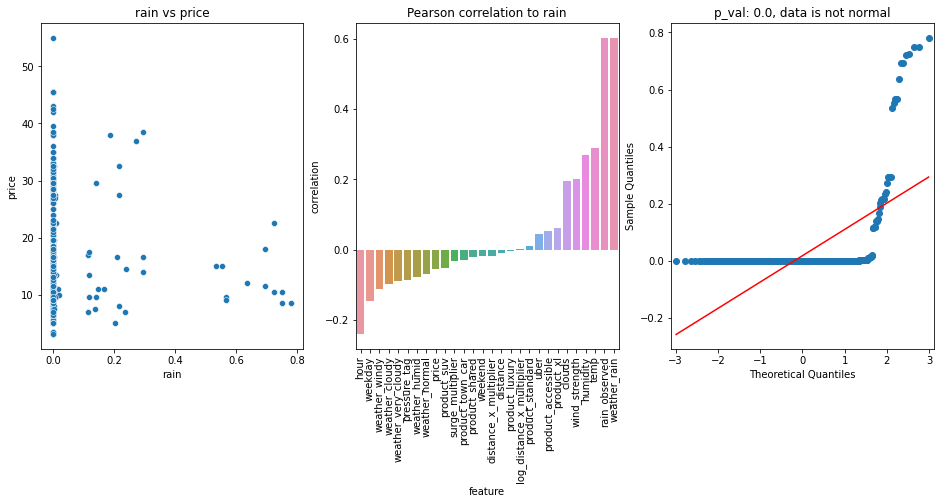





Exploring humidity


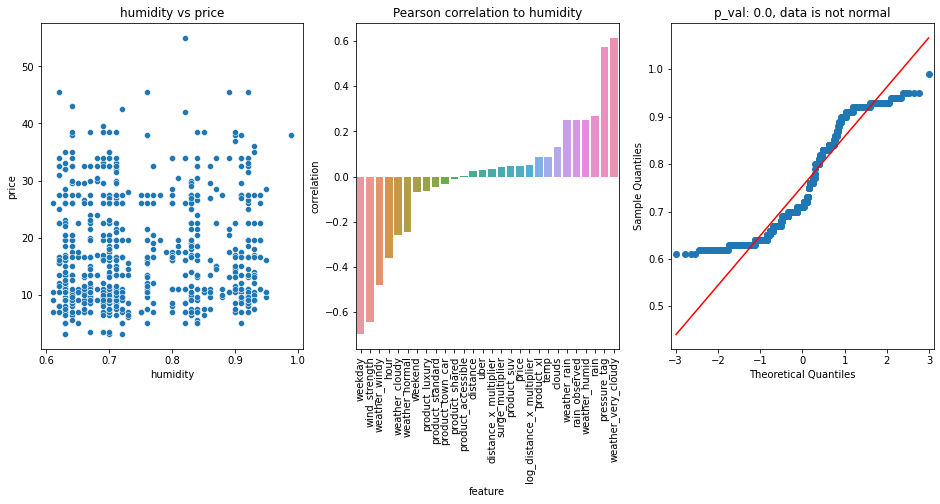





Exploring uber


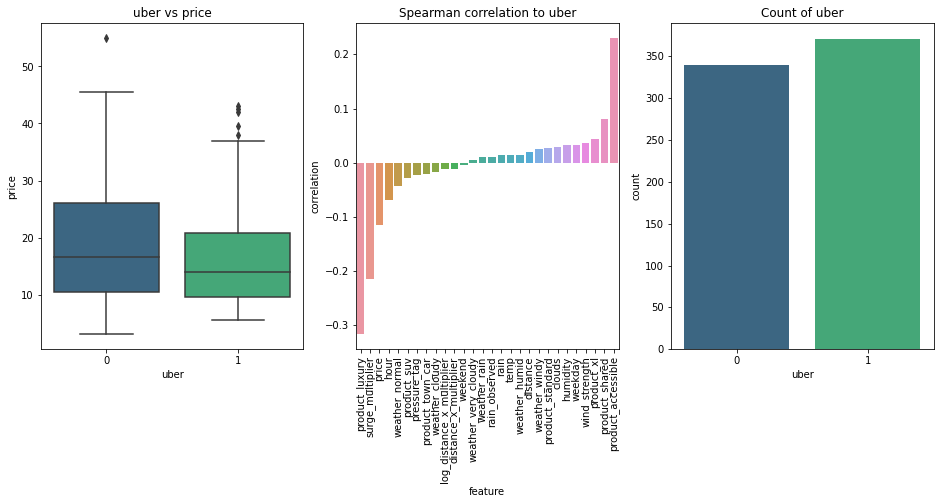





Exploring rain_observed


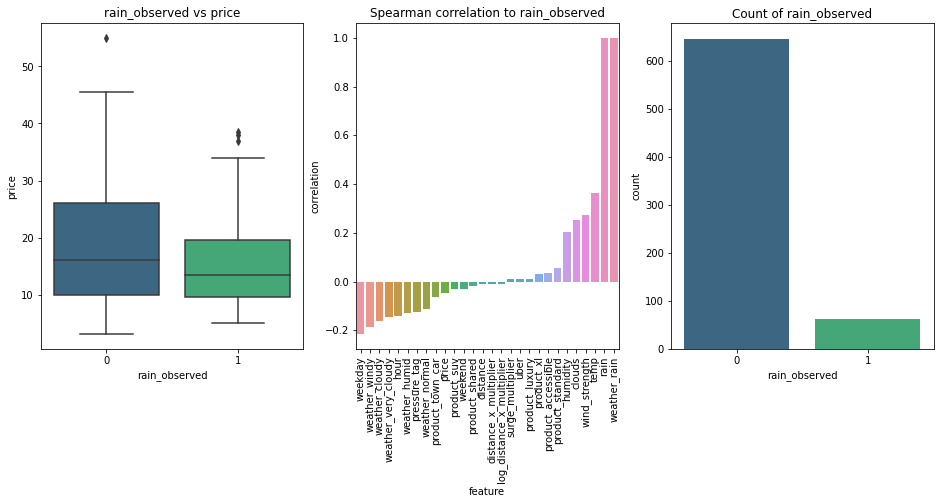





Exploring wind_strength


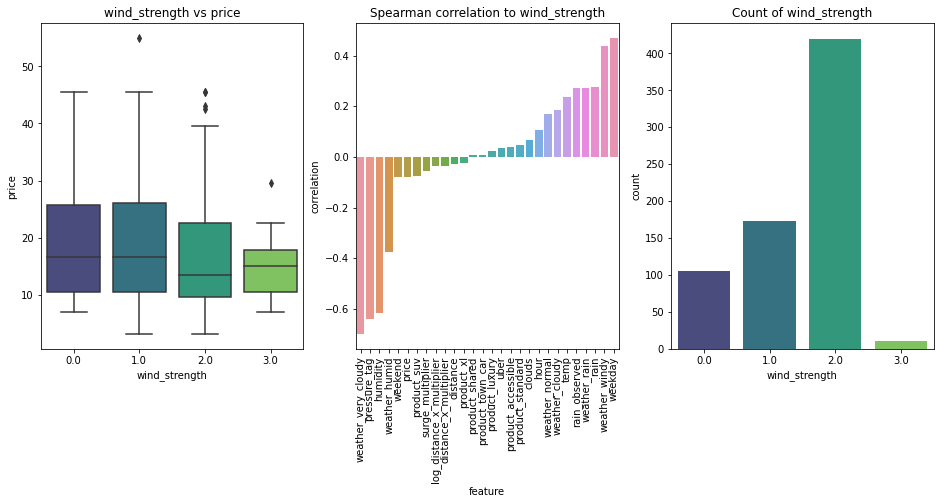





Exploring pressure_tag


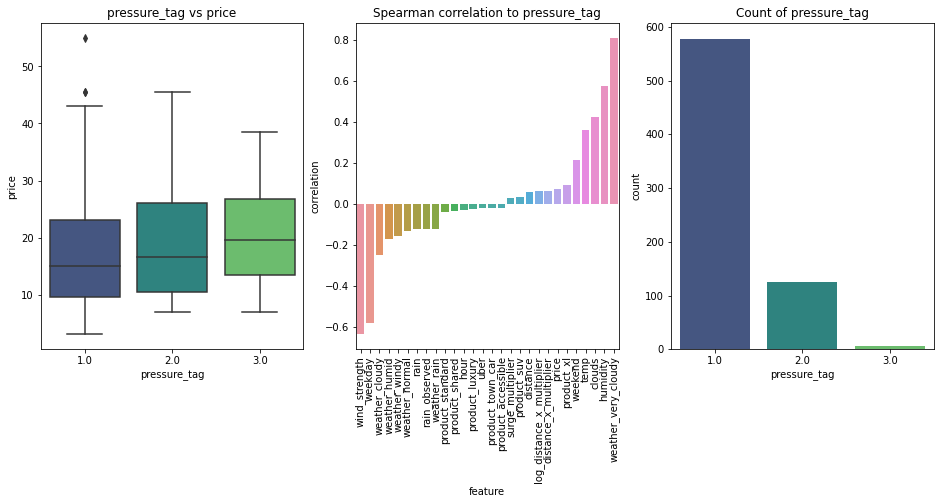





Exploring distance_x_multiplier


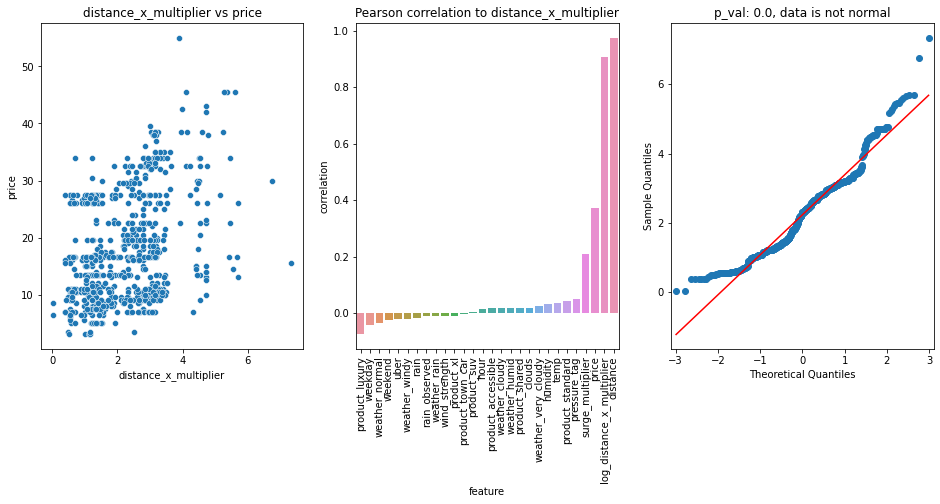





Exploring log_distance_x_multiplier


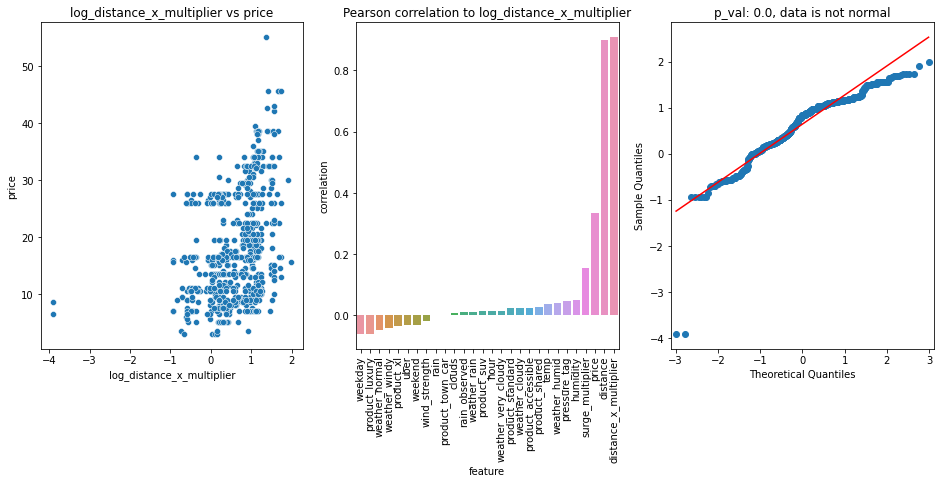





Exploring weekday


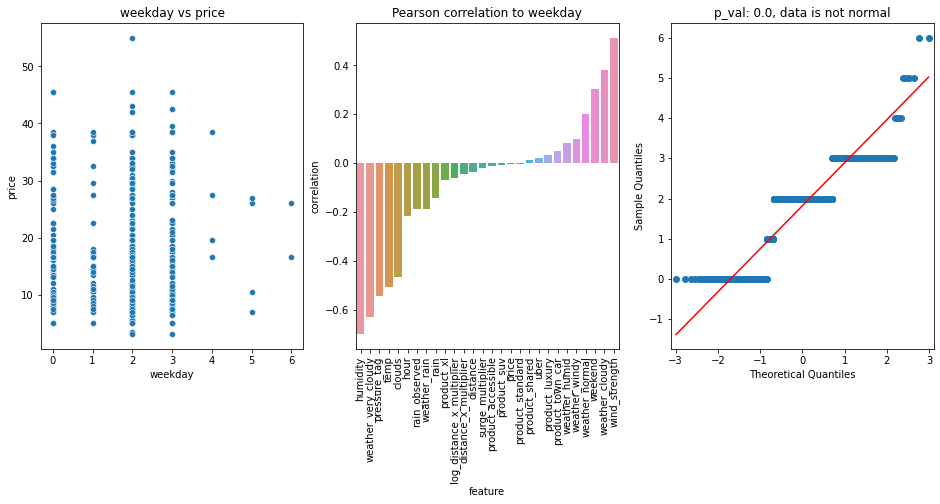





Exploring weekend


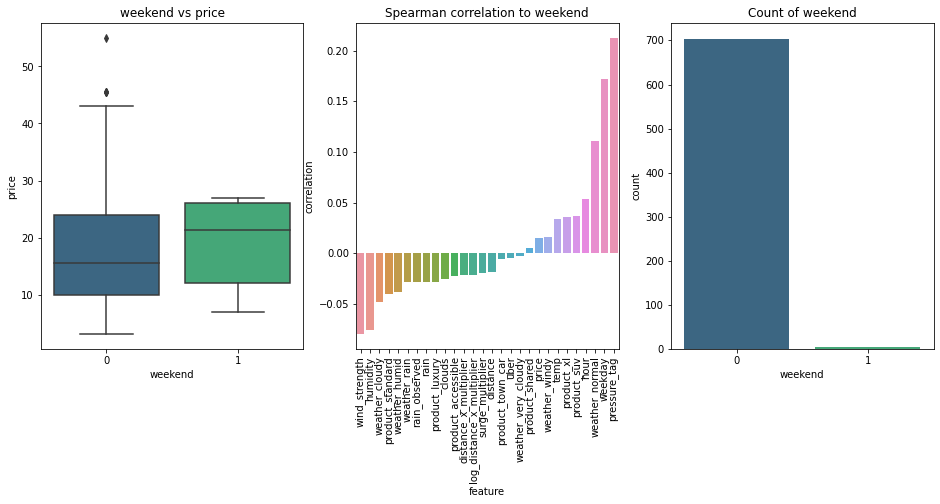





Exploring hour


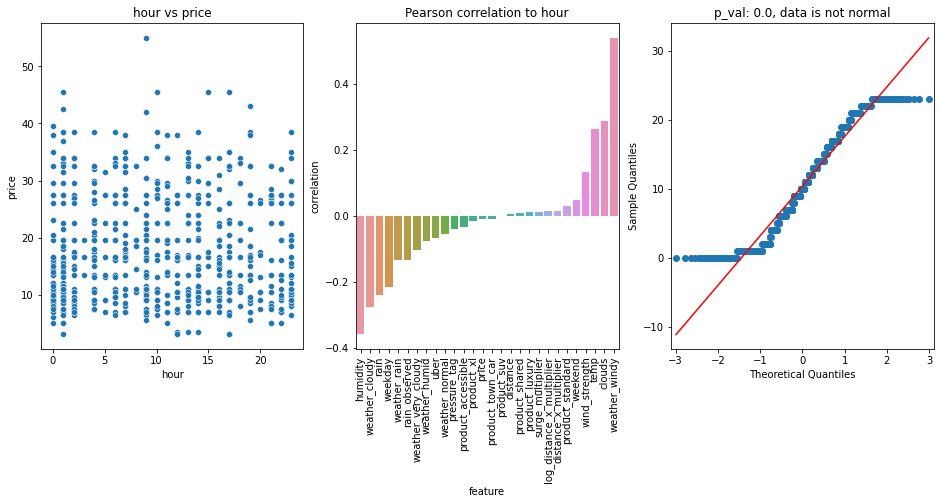





Exploring product_accessible


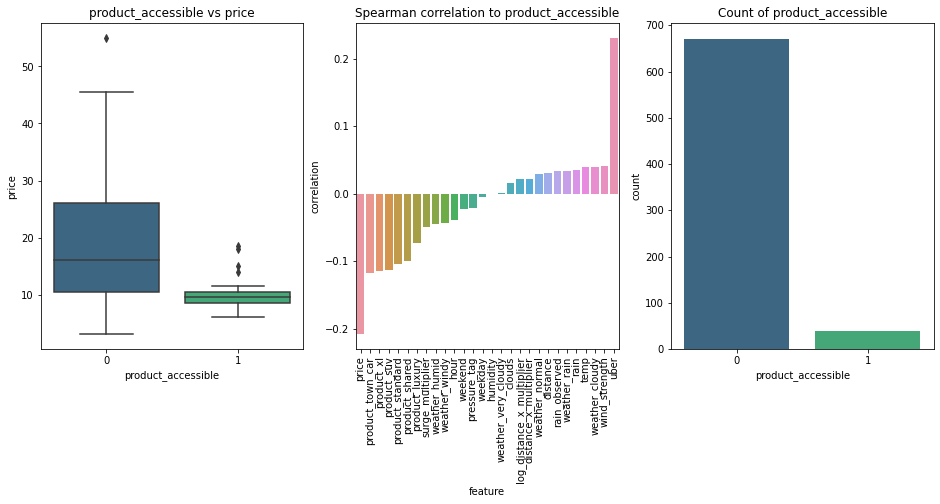





Exploring product_luxury


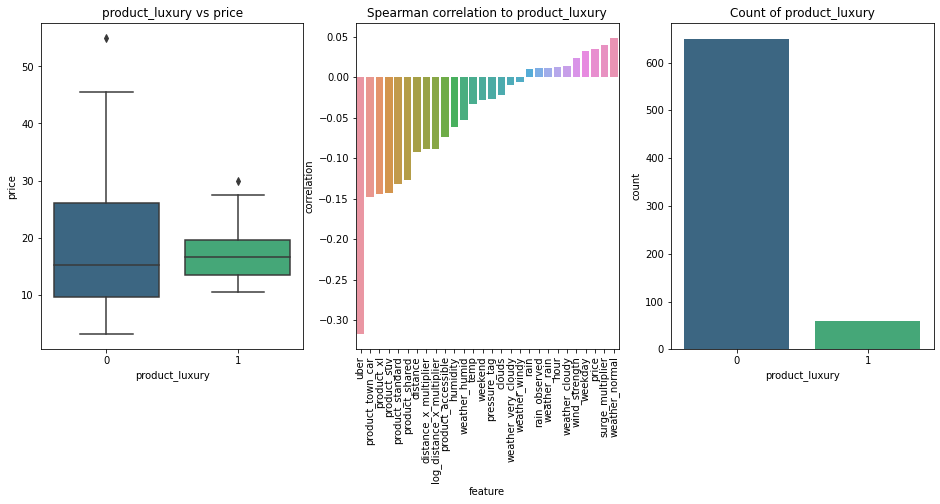





Exploring product_shared


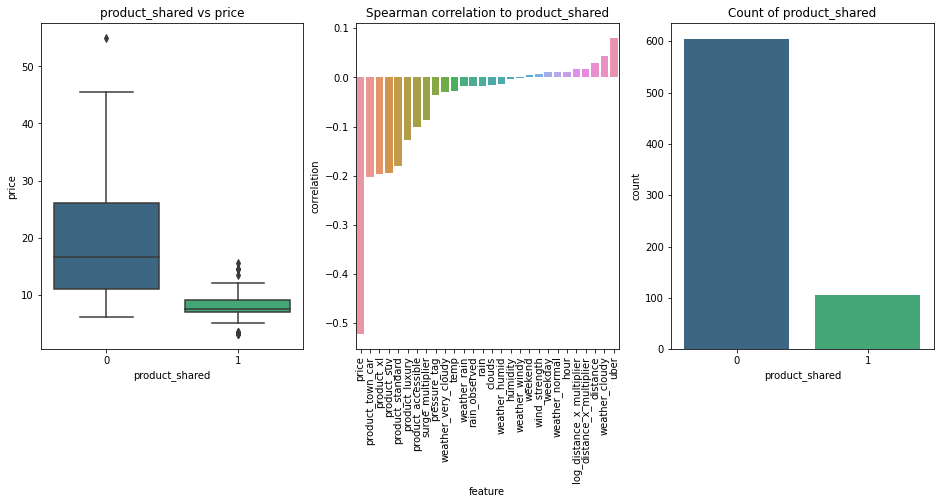





Exploring product_standard


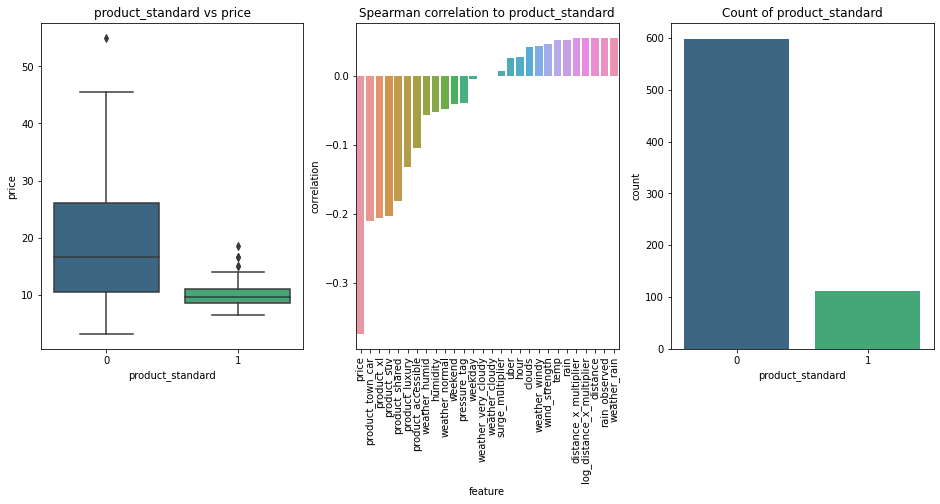





Exploring product_suv


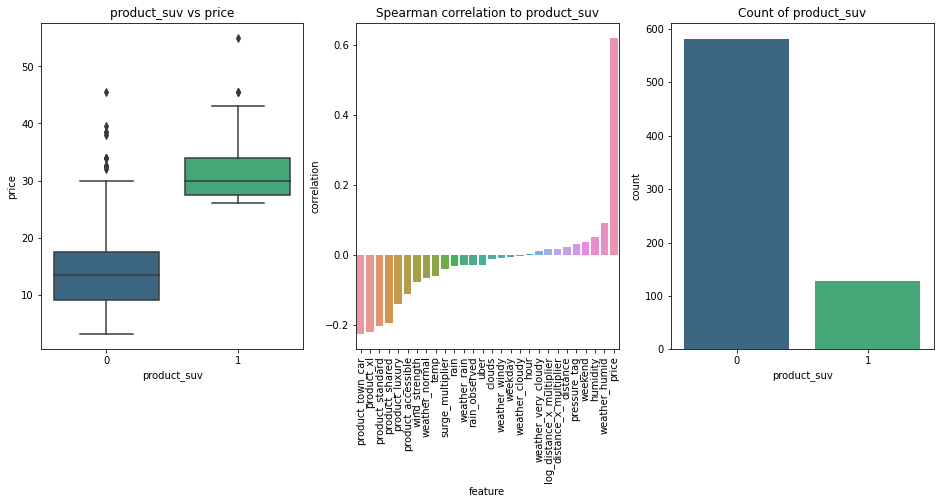





Exploring product_town_car


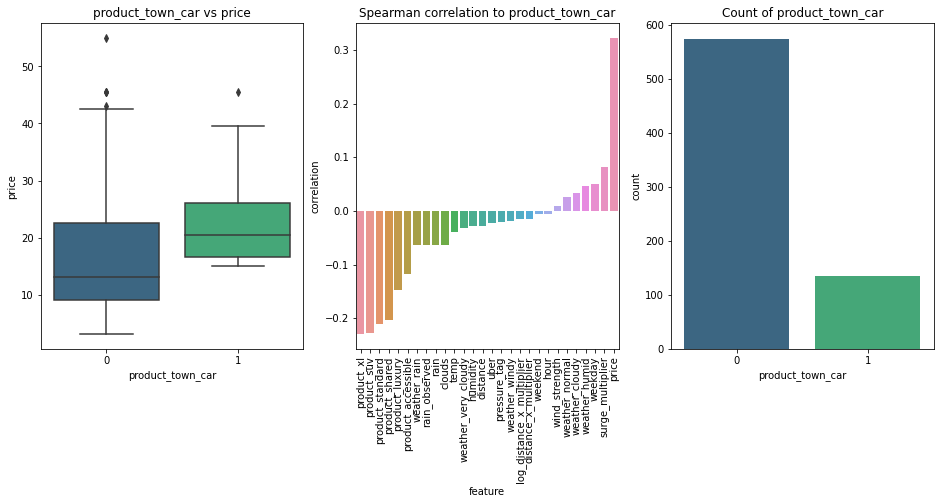





Exploring product_xl


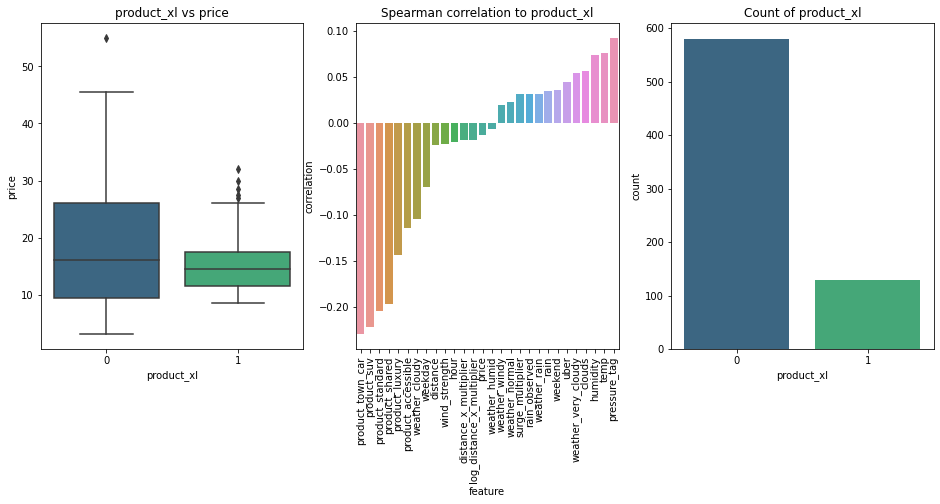





Exploring weather_cloudy


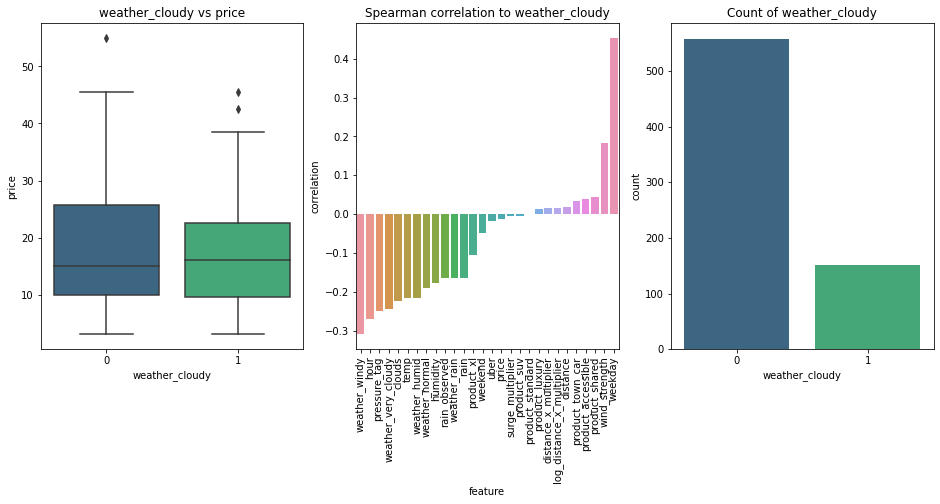





Exploring weather_humid


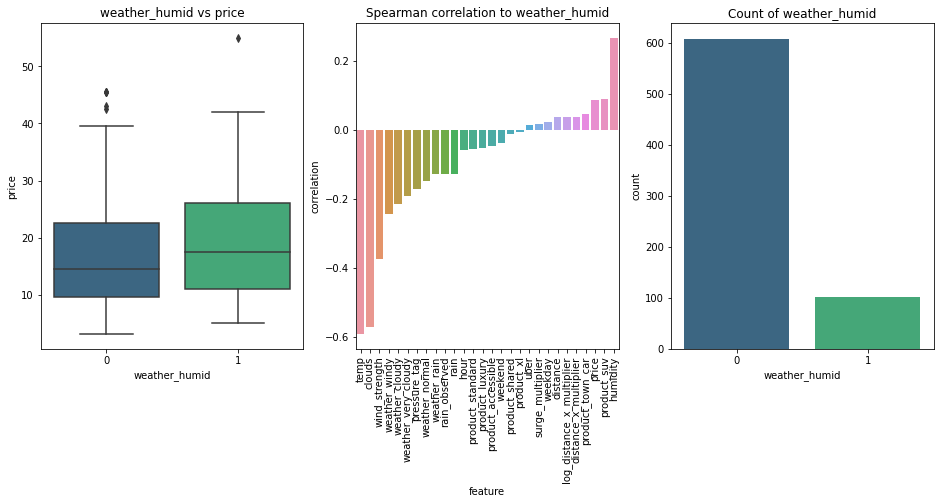





Exploring weather_normal


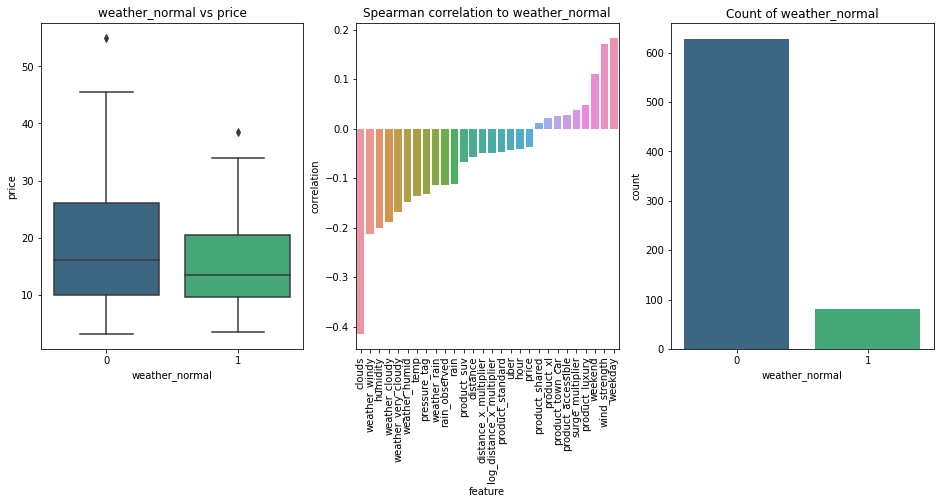





Exploring weather_rain


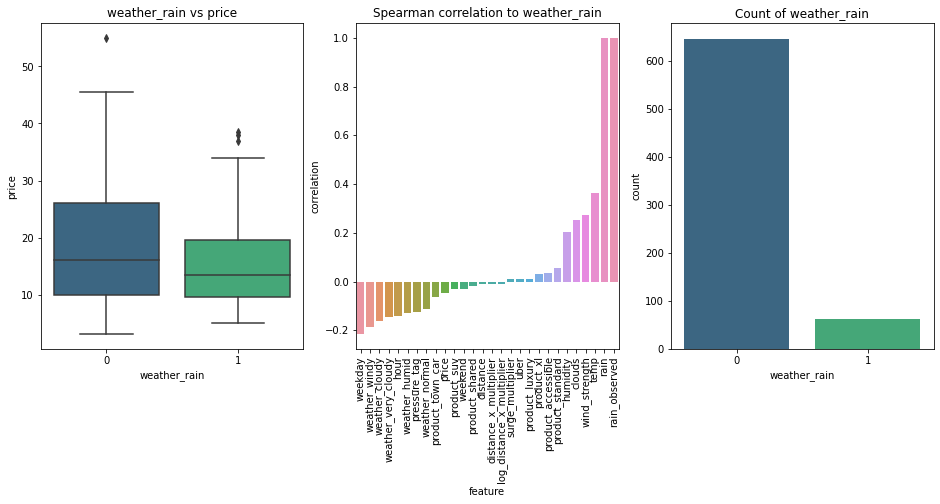





Exploring weather_very_cloudy


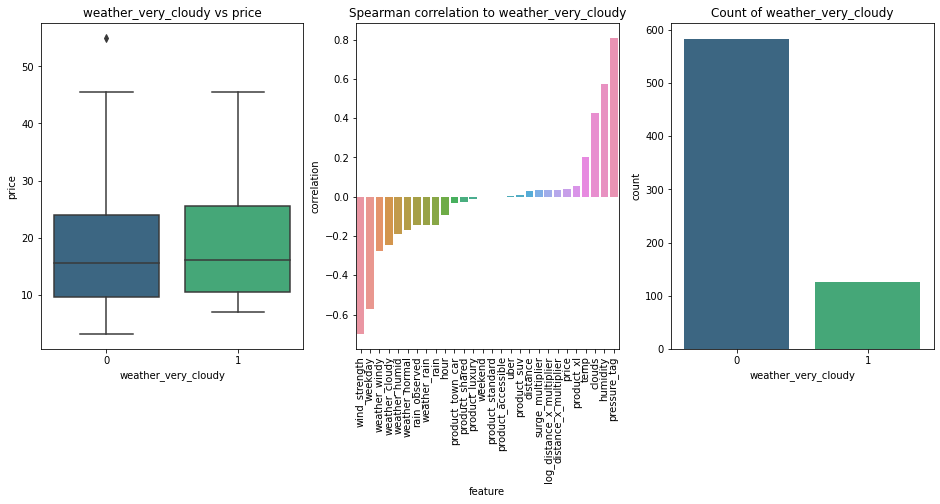





Exploring weather_windy


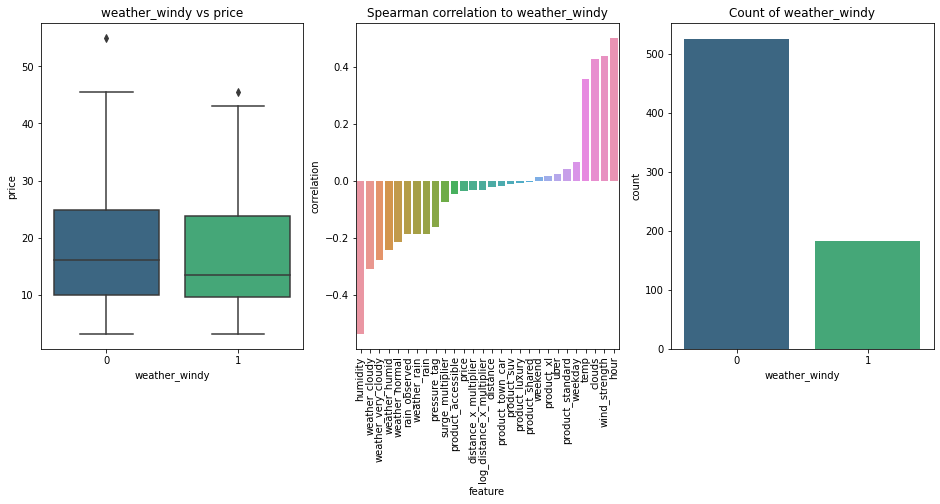

In [12]:
def explore_feature(data, feature, target='price'):
    
    values = data[feature].nunique()

    
    # plots for continuous features
    if values > 5:

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
        sns.scatterplot(x=feature, y=target, data=data, ax=ax1, )
        ax1.set_title(f'{feature} vs {target}')
        ax1.set_xlabel(f'{feature}')
        ax1.set_ylabel(f'{target}')
        
        # correlation to all features 
        corr_data = data.corr()[feature].reset_index()
        corr_data.columns = ['feature', 'correlation']
        corr_data = corr_data[corr_data['feature'] != feature].sort_values(by='correlation', ascending=True)
        
        sns.barplot(x='feature', y='correlation', data=corr_data, ax=ax2)
        ax2.set_xticklabels(corr_data['feature'], rotation=90)
        ax2.set_title(f'Pearson correlation to {feature}')
        
        probability = 0.05
        stat, p_val = shapiro(data[feature])

        sm.qqplot(data[feature], line='s', ax=ax3)

        if p_val < probability:
            ax3.set_title(f'p_val: {round(p_val, 2)}, data is not normal')
        else:
            ax3.set_title(f'p_val: {round(p_val, 2)}, data is normal')
        
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
        
        # boxplot 
        sns.boxplot(x=feature, y=target, data=data, ax=ax1, palette='viridis')
        ax1.set_title(f'{feature} vs {target}')
        ax1.set_xlabel(f'{feature}')
        ax1.set_ylabel(f'{target}')
        
        # Spearman rank correlations
        corr_data = data.corr(method='spearman')[feature].reset_index()
        corr_data.columns = ['feature', 'correlation']
        corr_data = corr_data[corr_data['feature'] != feature].sort_values(by='correlation', ascending=True)
        
        sns.barplot(x='feature', y='correlation', data=corr_data, ax=ax2)
        ax2.set_xticklabels(corr_data['feature'], rotation=90)
        ax2.set_title(f'Spearman correlation to {feature}')
        
        
        # count of occurances?
        sns.countplot(x=feature, data=data, ax=ax3, palette='viridis')
        ax3.set_title(f'Count of {feature}')
        ax3.set_xlabel(f'{feature}')

    print(f'Exploring {feature}')
    plt.show()
    print('\n\n\n')
        
#     return corr_data
    

features = df.drop('price', axis=1).columns
for feature in features:
    explore_feature(df, feature, target='price')

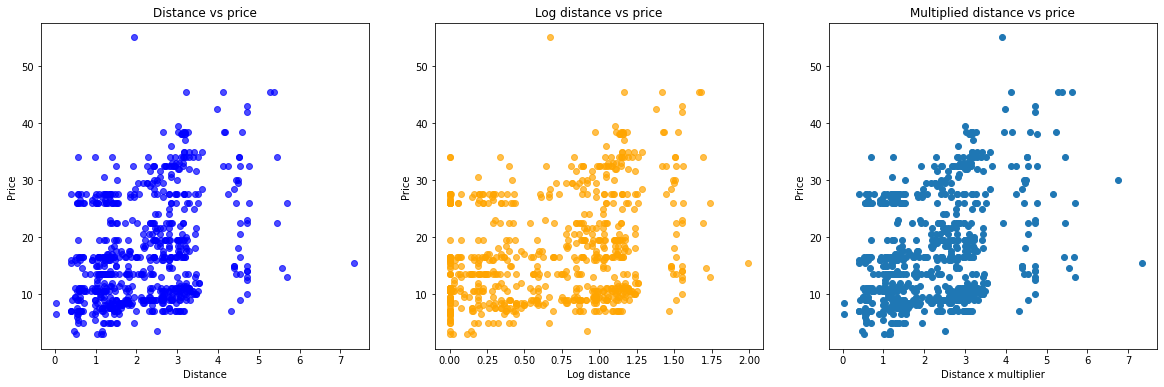

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# plot distance vs price 
ax1.scatter(df['distance'], df['price'], color='blue', alpha=0.7)
ax1.set_xlabel('Distance')
ax1.set_ylabel('Price')
ax1.set_title('Distance vs price')

# plot the log of distance vs the log of price
df['log_distance'] = np.where(np.log(df['distance']) > 0, np.log(df['distance']), 0)
ax2.scatter(df['log_distance'], df['price'], color='orange', alpha=0.7)
ax2.set_xlabel('Log distance')
ax2.set_ylabel('Price')
ax2.set_title('Log distance vs price')

# plot the distance vs the adjusted price
ax3.scatter(df['distance_x_multiplier'], df['price'])
ax3.set_xlabel('Distance x multiplier')
ax3.set_ylabel('Price')
ax3.set_title('Multiplied distance vs price')

plt.show()

(2.7180328365757798, 2.5528353190319386)

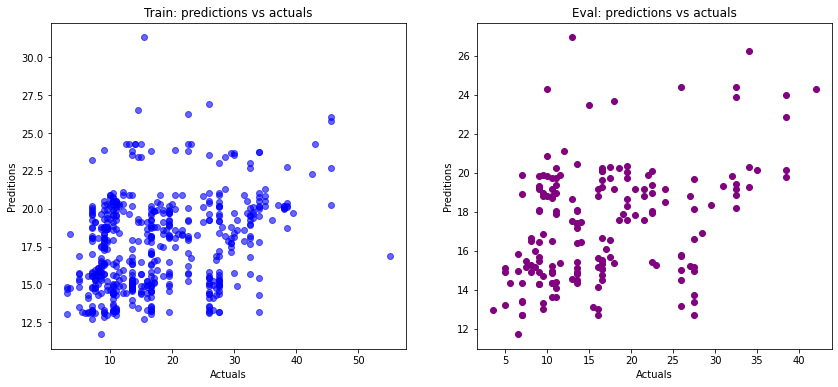

In [14]:
def basic_regression_model(data, plots=True):
#     data['log_price'] = 
    X = np.array(data['distance']).reshape(-1, 1)
    y = np.array(data['price']).reshape(-1, 1)
    
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.25, random_state=66)
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    eval_preds = model.predict(X_eval)
    train_rmse = np.sqrt(mean_absolute_error(y_train, train_preds))
    eval_rmse = np.sqrt(mean_absolute_error(y_eval, eval_preds))
    
    if plots:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        ax1.scatter(y_train, train_preds, color='blue', alpha=0.6)
        ax1.set_xlabel('Actuals')
        ax1.set_ylabel('Preditions')
        ax1.set_title('Train: predictions vs actuals')
        
        ax2.scatter(y_eval, eval_preds, color='purple')
        ax2.set_xlabel('Actuals')
        ax2.set_ylabel('Preditions')
        ax2.set_title('Eval: predictions vs actuals')
        
    return (train_rmse, eval_rmse)
    
basic_regression_model(df)

Using only distance as the input we get an RMSE of $2.55 per trip. Can we improve on this further by incorporting more features such as the rate modifier? If we use the log of distance the log of price this error drops further.

In [15]:
def feature_selector(data, n=5):
    
    # Split the data into x and y features
    X, y = data.drop('price', axis=1), data['price']
    
    # Split out categorical from continuous features for scaling
    X_cat, X_cont = [], []
    
    for feature in X.columns:
        if X[feature].nunique() > 5:
            X_cont.append(feature)
        else:
            X_cat.append(feature)
    
    # scale the continuous features & append to categorical features
    transformer = PowerTransformer()
    transformer.fit(data[X_cont])
    X_cont = pd.DataFrame(transformer.transform(data[X_cont]), index=X.index, columns=X_cont)
    X = pd.concat([data[X_cat], X_cont], axis=1)
    
    # create the model object & feature selector 
    model = LinearRegression()
    
    selector = SequentialFeatureSelector(model, n_features_to_select=n, direction='forward')
    selector.fit(X, y)
    
    features = X.columns 
    supports = selector.get_support()
    feature_df = pd.DataFrame({'features': features, 'supports': supports})
    selected_features = feature_df[feature_df['supports'] == True]['features']
    return selected_features


top_n_features = feature_selector(df, 15)
top_n_features

0          surge_multiplier
1                      uber
3             wind_strength
6        product_accessible
7            product_luxury
8            product_shared
9          product_standard
10              product_suv
11         product_town_car
12               product_xl
17      weather_very_cloudy
21                   clouds
22                     rain
24    distance_x_multiplier
28             log_distance
Name: features, dtype: object

In [16]:
def score_func(y, y_pred):
    
    error = mean_absolute_error(y, y_pred)
    error = np.sqrt(error)
    return error 


def fit_model(data, features, mdl=LinearRegression()):
    X = data[features]
    y = np.array(data['price']).reshape(-1, 1)
    
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.25, random_state=66)
    
    ### Scale the categorical features 
    columns, cat, cont = X_train.columns, [], []
    for column in columns:
        vals = X_train[column].nunique()
        if vals > 5:
            cont.append(column)
        else:
            cat.append(column)
            
    X_train_cat, X_train_cont = X_train[cat], X_train[cont]
    X_eval_cat, X_eval_cont = X_eval[cat], X_eval[cont]
    X_cat, X_cont = X[cat], X[cont]
    
    transformer = PowerTransformer()
    transformer.fit(X_train_cont)
    
    X_train_cont = pd.DataFrame(transformer.transform(X_train_cont), index=X_train_cont.index, columns=cont)
    X_eval_cont = pd.DataFrame(transformer.transform(X_eval_cont), index=X_eval_cont.index, columns=cont)
    X_cont = pd.DataFrame(transformer.transform(X_cont), index=X_cont.index, columns=cont)
    
    X_train = pd.concat([X_train_cont, X_train_cat], axis=1) 
    X_eval = pd.concat([X_eval_cont, X_eval_cat], axis=1)
    X_tr = pd.concat([X_cont, X_cat], axis=1)
    
    ### Fit and train the model
    model = mdl
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    eval_preds = model.predict(X_eval)
    train_rmse = np.sqrt(mean_absolute_error(y_train, train_preds))
    eval_rmse = np.sqrt(mean_absolute_error(y_eval, eval_preds))
        
    cross_val = cross_val_score(model, X_tr, y, cv=5, scoring=make_scorer(score_func))
    cv_scores = np.mean(np.abs(cross_val))
    
    # coef 
    coef = eval_rmse / y.mean()
    
    results = {
        'train_rmse': round(train_rmse, 3),
        'test_rmse': round(eval_rmse, 3),
        'cv_rmse': round(cv_scores, 3),
        'coef': round(coef, 3)
    }
    return results
    
    
df_coef = df['price'].std() / df['price'].mean()
lin = fit_model(df, 
                list(top_n_features), 
                LinearRegression())
rf = fit_model(df,
               list(top_n_features),
               RandomForestRegressor(n_estimators=100, max_depth=6, criterion='absolute_error'))
bst = fit_model(df, 
                list(top_n_features),
                xgb.XGBRegressor(max_depth=6,
                                 n_estimators=500,
                                 base_score=0.5, 
                                 gamma=0.2,
                                 random_state=66))


print(f'Coef of evaluation for data: {round(df_coef, 3)}\n')
print("Linear", lin)
print('\n')
print("Random Forest", rf)
print('\n')
print("XGB Regressor", bst)

Coef of evaluation for data: 0.531

Linear {'train_rmse': 1.37, 'test_rmse': 1.423, 'cv_rmse': 1.4, 'coef': 0.082}


Random Forest {'train_rmse': 1.06, 'test_rmse': 1.199, 'cv_rmse': 1.239, 'coef': 0.069}


XGB Regressor {'train_rmse': 0.52, 'test_rmse': 1.236, 'cv_rmse': 1.273, 'coef': 0.071}


A Linear model returns an error 

In [17]:
def model_tuning(data, features, folds=5):
    
    # Create the X and y arrays
    X = data[features]
    y = np.array(data['price']).reshape(-1, 1)
    
    ### Scale the categorical features 
    columns, cat, cont = X.columns, [], []
    for column in columns:
        vals = X[column].nunique()
        if vals > 5:
            cont.append(column)
        else:
            cat.append(column)
            
    X_cat, X_cont = X[cat], X[cont]
    
    transformer = PowerTransformer()
    transformer.fit(X_cont)
    
    X_cont = pd.DataFrame(transformer.transform(X_cont), index=X_cont.index, columns=cont)
    
    X = pd.concat([X_cont, X_cat], axis=1) 
    
    param_grid = { 
    'n_estimators': [100, 300, 500],
    'criterion': ['mse', "absolute_error", "poisson"], 
    'max_depth': [0, 2, 4, 6, 8, 10],
    'max_features': ["auto", "sqrt", "log2"]
    }

    
    cv = GridSearchCV(estimator=RandomForestRegressor(random_state=66, n_jobs=-1),
                      param_grid=param_grid,
                      scoring=make_scorer(score_func),
                      cv=folds)
    cv.fit(X, y)
    
    return cv.best_params_


model_tuning(df, list(top_n_features), folds=10)
### {'learning_rate': 0.8, 'max_depth': 6, 'max_leaves': 0, 'n_estimators': 100}

{'criterion': 'poisson',
 'max_depth': 2,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [18]:
tuned_xgb = fit_model(df,
                      list(top_n_features),
                      RandomForestRegressor(max_depth=2,
                                            criterion='poisson',
                                            max_features='sqrt',
                                            n_estimators=300,
                                            random_state=66,
                                            n_jobs=-1))

print('Turned RF Regressor:', tuned_xgb)

Turned RF Regressor: {'train_rmse': 2.562, 'test_rmse': 2.439, 'cv_rmse': 2.52, 'coef': 0.141}
